In [28]:
%matplotlib inline

import warnings
import os
from pathlib import Path
import quandl
import numpy as np
from numpy.random import choice, normal
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, BaggingClassifier, BaggingRegressor
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, cross_val_score
from sklearn.metrics import roc_auc_score, roc_curve, mean_squared_error, precision_recall_curve
from sklearn.externals import joblib
warnings.filterwarnings('ignore')

In [2]:
plt.style.use('fivethirtyeight')
np.random.seed(seed=42)

## Get Data

In [15]:
with pd.HDFStore('data.h5') as store:
    data =store['data']
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 174551 entries, (A, 2011-02-28 00:00:00) to (ZUMZ, 2018-03-31 00:00:00)
Data columns (total 62 columns):
returns                  174551 non-null float64
t-1                      174551 non-null float64
t-2                      174551 non-null float64
t-3                      174551 non-null float64
t-4                      174551 non-null float64
t-5                      174551 non-null float64
t-6                      174551 non-null float64
t-7                      174551 non-null float64
t-8                      174551 non-null float64
t-9                      174551 non-null float64
t-10                     174551 non-null float64
t-11                     174551 non-null float64
t-12                     174551 non-null float64
year_2010                174551 non-null uint8
year_2011                174551 non-null uint8
year_2012                174551 non-null uint8
year_2013                174551 non-null uint8
year_2014           

### Stock Prices

In [16]:
y = data.returns
y_binary = (y > 0).astype(int)
X = data.drop('returns', axis=1)

## Explore Data

In [17]:
y.describe(percentiles=np.arange(.1, .91, .1))

count    174551.000000
mean          0.009913
std           0.055606
min          -0.128560
10%          -0.064080
20%          -0.036451
30.0%        -0.017798
40%          -0.002855
50%           0.010522
60%           0.023904
70%           0.038457
80%           0.056050
90%           0.082772
max           0.146335
Name: returns, dtype: float64

## Custom KFold

In [18]:
class OneStepTimeSeriesSplit:
    """Generates tuples of train_idx, test_idx pairs
    Assumes the index contains a level labeled 'date'"""

    def __init__(self, n_splits=3, test_period_length=1, shuffle=False):
        self.n_splits = n_splits
        self.test_period_length = test_period_length
        self.shuffle = shuffle

    @staticmethod
    def chunks(l, n):
        for i in range(0, len(l), n):
            yield l[i:i + n]

    def split(self, X, y=None, groups=None):
        unique_dates = (X.index
                        .get_level_values('date')
                        .unique()
                        .sort_values(ascending=False)
                        [:self.n_splits*self.test_period_length])

        dates = X.reset_index()[['date']]
        for test_date in self.chunks(unique_dates, self.test_period_length):
            train_idx = dates[dates.date < min(test_date)].index
            test_idx = dates[dates.date.isin(test_date)].index
            if self.shuffle:
                np.random.shuffle(list(train_idx))
            yield train_idx, test_idx

    def get_n_splits(self, X, y, groups=None):
        return self.n_splits

## Benchmarks

### Regression

In [19]:
def regression_benchmark():
    rmse = []
    for train_idx, test_idx in cv.split(X):
        mean = y.iloc[train_idx].mean()
        data = y.iloc[test_idx].to_frame('y_test').assign(y_pred=mean)
        rmse.append(np.sqrt(mean_squared_error(data.y_test, data.y_pred))) 
    return np.mean(rmse)

### Classification

In [20]:
def classification_benchmark():
    auc = []
    for train_idx, test_idx in cv.split(X):
        mean = y_binary.iloc[train_idx].mean()
        data = y_binary.iloc[test_idx].to_frame('y_test').assign(y_pred=mean)
        auc.append(roc_auc_score(data.y_test, data.y_pred))
    return np.mean(auc)

## Bagging

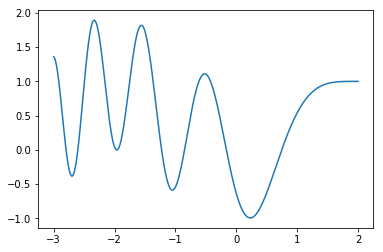

In [21]:
def f(x):
    return np.exp(-(x+2) ** 2) + np.cos((x-2)**2)

x = np.linspace(-3, 2, 1000)
y = pd.Series(f(x), index=x)
y.plot();

In [22]:
test_size = 500
train_size = 250
reps = 100

noise = .5  # noise relative to std(y)
noise = y.std() * noise

X_test = choice(x, size=test_size, replace=False)

max_depth = 10
n_estimators=10

tree = DecisionTreeRegressor(max_depth=max_depth)
bagged_tree = BaggingRegressor(base_estimator=tree, n_estimators=n_estimators)
learners = {'Decision Tree': tree, 'Bagging Regressor': bagged_tree}

predictions = {k: pd.DataFrame() for k, v in learners.items()}
for i in range(reps):
    X_train = choice(x, train_size)
    y_train = f(X_train) + normal(scale=noise, size=train_size)
    for label, learner in learners.items():
        learner.fit(X=X_train.reshape(-1, 1), y=y_train)
        preds = pd.DataFrame({i: learner.predict(X_test.reshape(-1, 1))}, index=X_test)
        predictions[label] = pd.concat([predictions[label], preds], axis=1)

In [23]:
# y only observed with noise
y_true = pd.Series(f(X_test), index=X_test)
y_test = pd.DataFrame(y_true.values.reshape(-1,1) + normal(scale=noise, size=(test_size, reps)), index=X_test)

In [24]:
result = pd.DataFrame()
for label, preds in predictions.items():
    result[(label, 'error')] = preds.sub(y_test, axis=0).pow(2).mean(1)    # mean squared error
    result[(label, 'bias')] = y_true.sub(preds.mean(axis=1), axis=0).pow(2)             # bias
    result[(label, 'variance')] = preds.var(axis=1)
    result[(label, 'noise', )] = y_test.var(axis=1)
result.columns = pd.MultiIndex.from_tuples(result.columns)

In [25]:
df = result.mean().sort_index().loc['Decision Tree']
f"{(df.error- df.drop('error').sum()) / df.error:.2%}"

'-1.13%'

In [26]:
df = result.mean().sort_index().loc['Bagging Regressor']
f"{(df.error- df.drop('error').sum()) / df.error:.2%}"

'-0.84%'

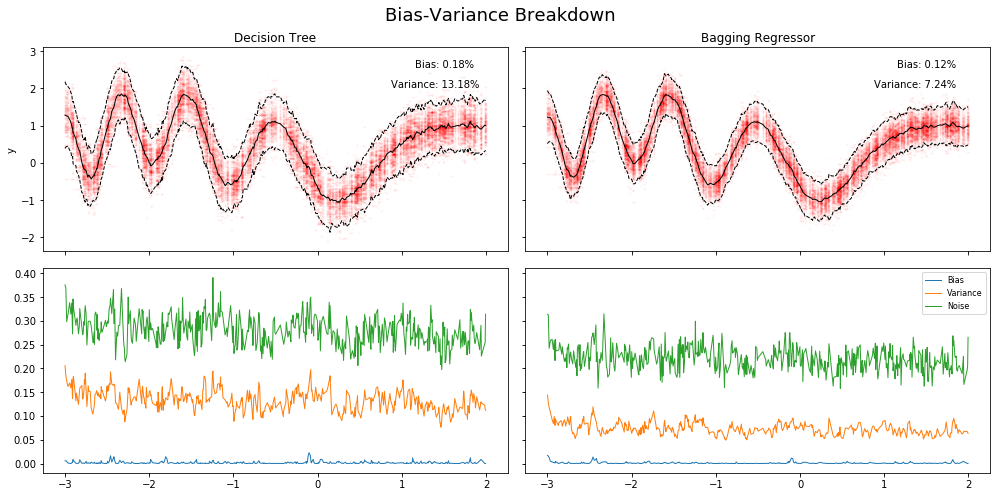

In [27]:
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(14, 7), sharex=True, sharey='row')
axes = axes.flatten()
idx = pd.IndexSlice

for i, (model, data) in enumerate(predictions.items()):
    mean, std = data.mean(1), data.std(1).mul(2)
    (pd.DataFrame([mean.sub(std), mean, mean.add(std)]).T
     .sort_index()
     .plot(style=['k--', 'k-', 'k--'], ax=axes[i], lw=1, legend=False))
    (data.stack().reset_index()
     .rename(columns={'level_0': 'x', 0: 'y'})
     .plot.scatter(x='x', y='y', ax=axes[i], alpha=.02, s=2, color='r', title=model))
    r = result[model]
    m = r.mean()
    kwargs = {'transform': axes[i].transAxes, 'fontsize':10}
    axes[i].text(x=.8, y=.9, s=f'Bias: {m.bias:.2%}', **kwargs)
    axes[i].text(x=.75, y=.8, s=f'Variance: {m.variance:.2%}', **kwargs)
    
    (r.drop('error', axis=1).sort_index()
     .rename(columns=str.capitalize)
     .plot(ax=axes[i+2], lw=1, legend=False, stacked=True))

axes[-1].legend(fontsize=8)
fig.suptitle('Bias-Variance Breakdown', fontsize=18)
fig.tight_layout()
fig.subplots_adjust(top=.9)
fig.savefig('bias_variance_bagging', dpi=600);

## Random Forests

### Classifier

### Cross-Validation with default settings

In [11]:
rf_clf = RandomForestClassifier(n_estimators=200,             # will change from 10 to 100 in version 0.22 
                                criterion='gini', 
                                max_depth=None, 
                                min_samples_split=2, 
                                min_samples_leaf=1, 
                                min_weight_fraction_leaf=0.0, 
                                max_features='auto',
                                max_leaf_nodes=None, 
                                min_impurity_decrease=0.0, 
                                min_impurity_split=None, 
                                bootstrap=True, 
                                oob_score=True, 
                                n_jobs=-1,
                                random_state=42, 
                                verbose=1)

In [12]:
cv = OneStepTimeSeriesSplit(n_splits=12, test_period_length=1, shuffle=True)

In [13]:
cv_score = cross_val_score(estimator=rf_clf,
                           X=X,
                           y=y_binary,
                           scoring='roc_auc',
                           cv=cv,
                           n_jobs=-1,
                           verbose=1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  12 | elapsed:  3.8min remaining:   45.7s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:  3.8min finished


In [14]:
np.mean(cv_score)

0.5884605748426195

### Parameter Tuning

#### Defne Parameter Grid

In [29]:
param_grid = {'n_estimators': [200, 400],
              'max_depth': [10, 15, 20],
              'min_samples_leaf': [50, 100],
              }

#### Instantiate GridSearchCV

In [30]:
gridsearch_clf = GridSearchCV(estimator=rf_clf,
                              param_grid=param_grid,
                              scoring='roc_auc',
                              n_jobs=-1,
                              cv=cv,
                              refit=True,
                              return_train_score=True,
                              verbose=1)

#### Fit

In [31]:
gridsearch_clf.fit(X=X, y=y_binary)

Fitting 12 folds for each of 12 candidates, totalling 144 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  8.1min
[Parallel(n_jobs=-1)]: Done 144 out of 144 | elapsed: 44.0min finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   11.3s
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:   24.0s finished


GridSearchCV(cv=<__main__.OneStepTimeSeriesSplit object at 0x7f7fda09c048>,
       error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=-1,
            oob_score=True, random_state=42, verbose=1, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'n_estimators': [200, 400], 'max_depth': [10, 15, 20], 'min_samples_leaf': [50, 100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=1)

#### Perist Result

In [ ]:
joblib.dump(gridsearch_clf, 'gridsearch_clf.joblib') 

In [33]:
gridsearch_clf.best_params_

{'max_depth': 15, 'min_samples_leaf': 100, 'n_estimators': 400}

In [34]:
gridsearch_clf.best_score_

0.6012559235004928

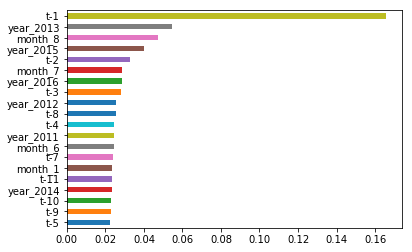

In [38]:
(pd.Series(gridsearch_clf.best_estimator_.feature_importances_, 
           index=X.columns)
 .sort_values(ascending=False)
 .iloc[:20]
 .sort_values()
 .plot.barh());

### Regression

In [ ]:
rf_reg = RandomForestRegressor(n_estimators=10, 
                                max_depth=None, 
                                min_samples_split=2, 
                                min_samples_leaf=1, 
                                min_weight_fraction_leaf=0.0, 
                                max_features='auto', 
                                max_leaf_nodes=None, 
                                min_impurity_decrease=0.0, 
                                min_impurity_split=None, 
                                bootstrap=True, 
                                oob_score=False, 
                                n_jobs=-1, 
                                random_state=None, 
                                verbose=0, 
                                warm_start=False)

In [ ]:
gridsearch_reg = GridSearchCV(estimator=rf_reg,
                              param_grid=param_grid,
                              scoring='neg_mean_squared_error',
                              n_jobs=-1,
                              cv=cv,
                              refit=True,
                              return_train_score=True,
                              verbose=1)

In [ ]:
gridsearch_reg.fit(X=X, y=y)

In [ ]:
joblib.dump(gridsearch_reg, 'rf_reg_gridsearch.joblib') 

In [ ]:
gridsearch_reg.best_params_

In [ ]:
f'{np.sqrt(-gridsearch_reg.best_score_):.2%}'

In [ ]:
f'{regression_benchmark():.2%}'

In [ ]:
rf_reg = RandomForestRegressor(n_estimators=1, 
                                max_depth=None, 
                                min_samples_split=2, 
                                min_samples_leaf=1, 
                                min_weight_fraction_leaf=0.0, 
                                max_features='auto', 
                                max_leaf_nodes=None, 
                                min_impurity_decrease=0.0, 
                                min_impurity_split=None, 
                                bootstrap=True, 
                                oob_score=False, 
                                n_jobs=-1, 
                                random_state=None, 
                                verbose=0, 
                                warm_start=False)